1. Importação e Configuração

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy.sparse import hstack

# Configurações visuais
sns.set(style="whitegrid")
nltk.download('stopwords')

# CARREGAR DADOS
df = pd.read_csv('airlines_reviews.csv') 

# Visualizar as primeiras linhas e colunas
print(df.head())
print(df.info())

                                  Title              Name Review Date  \
0                    Flight was amazing  Alison Soetantyo  2024-03-01   
1  seats on this aircraft are dreadful      Robert Watson  2024-02-21   
2          Food was plentiful and tasty             S Han  2024-02-20   
3          “how much food was available          D Laynes  2024-02-19   
4       “service was consistently good”         A Othman   2024-02-19   

              Airline Verified  \
0  Singapore Airlines     True   
1  Singapore Airlines     True   
2  Singapore Airlines     True   
3  Singapore Airlines     True   
4  Singapore Airlines     True   

                                             Reviews Type of Traveller  \
0    Flight was amazing. The crew onboard this fl...      Solo Leisure   
1    Booking an emergency exit seat still meant h...      Solo Leisure   
2    Excellent performance on all fronts. I would...    Family Leisure   
3   Pretty comfortable flight considering I was f...      So

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mathe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2. Pré-processamento e Limpeza

In [ ]:
# 1. Definir Variável Alvo (Target)
# Converter 'yes'/'no' para 1/0
df['Target'] = df['Recommended'].map({'yes': 1, 'no': 0})

# Remover linhas onde o alvo é nulo
df = df.dropna(subset=['Target'])

# 2. Separar Features
cols_tabulares = [
    'Overall Rating', 
    'Seat Comfort', 
    'Staff Service'
    'Value For Money', 
    'Food & Beverages', 
    'Inflight Entertainment'
]

col_texto = 'Reviews'

# Tratamento dde nulos nas tabulares
for col in cols_tabulares:
    if col in df.columns:
        # Força conversão para numérico, caso haja texto misturado, transformando erros em NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].fillna(df[col].median())
    else:
        print(f"Aviso: Coluna '{col}' não encontrada no dataset.")

# Limpeza básica do Texto
stop_words = set(stopwords.words('english'))

def limpar_texto(text):
    if not isinstance(text, str): return ""
    text = text.lower() # Minúsculas
    text = re.sub(r'[^\w\s]', '', text) # Remover pontuação
    text = " ".join([word for word in text.split() if word not in stop_words]) # Remover stopwords
    return text


df['Clean_Review'] = df[col_texto].apply(limpar_texto)

# Divisão Treino e Teste
X = df
y = df['Target']

# Stratify garante que a proporção de Yes/No seja igual no treino e no teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Dados processados com sucesso!")

Dados processados com sucesso!


3. Modelo 1: Apenas Dados Tabulares

In [8]:
print("--- MODELO 1: Apenas Tabulares ---")

# Selecionar apenas colunas tabulares existentes
features_tab = [c for c in cols_tabulares if c in df.columns]

# Modelo: Random Forest (bom para dados tabulares)
model_tab = RandomForestClassifier(n_estimators=100, random_state=42)

# Treino
model_tab.fit(X_train[features_tab], y_train)

# Predição
y_pred_tab = model_tab.predict(X_test[features_tab])

# Avaliação
print(classification_report(y_test, y_pred_tab))
acc_tab = accuracy_score(y_test, y_pred_tab)

--- MODELO 1: Apenas Tabulares ---
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1144
           1       0.93      0.93      0.93      1286

    accuracy                           0.93      2430
   macro avg       0.93      0.93      0.93      2430
weighted avg       0.93      0.93      0.93      2430



4. Modelo 2: Apenas Dados Textuais (NLP)

In [ ]:
print("--- MODELO 2: Apenas Texto ---")

# Vetorização (TF-IDF)
# max_features=5000 limita as 5000 palavras mais importantes para não pesar a memória
tfidf = TfidfVectorizer(max_features=5000)

X_train_tfidf = tfidf.fit_transform(X_train['Clean_Review'])
X_test_tfidf = tfidf.transform(X_test['Clean_Review'])

# Modelo: Regressão Logística
model_text = LogisticRegression(max_iter=1000)
model_text.fit(X_train_tfidf, y_train)

# Predição
y_pred_text = model_text.predict(X_test_tfidf)

# Avaliação
print(classification_report(y_test, y_pred_text))
acc_text = accuracy_score(y_test, y_pred_text)

--- MODELO 2: Apenas Texto ---
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1144
           1       0.90      0.91      0.90      1286

    accuracy                           0.90      2430
   macro avg       0.90      0.90      0.90      2430
weighted avg       0.90      0.90      0.90      2430



5. Modelo 3: Combinado (Tabular + Texto)

In [ ]:
print("--- MODELO 3: Híbrido (Texto + Tabular) ---")

# Normalizar dados tabulares pode ajudar (MinMaxScaler ou StandardScaler), mas Random Forest/LogReg aguentam bem sem.

# Juntar as matrizes
X_train_hybrid = hstack([X_train_tfidf, X_train[features_tab]])
X_test_hybrid = hstack([X_test_tfidf, X_test[features_tab]])

# Modelo Híbrido
model_hybrid = LogisticRegression(max_iter=1000)
model_hybrid.fit(X_train_hybrid, y_train)

# Predição
y_pred_hybrid = model_hybrid.predict(X_test_hybrid)

# Avaliação
print(classification_report(y_test, y_pred_hybrid))
acc_hybrid = accuracy_score(y_test, y_pred_hybrid)

--- MODELO 3: Híbrido (Texto + Tabular) ---
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1144
           1       0.95      0.95      0.95      1286

    accuracy                           0.94      2430
   macro avg       0.94      0.94      0.94      2430
weighted avg       0.94      0.94      0.94      2430



6. Análise de Importância das Palavras (Top 20)

Top Palavras para RECOMENDAÇÃO:
              word      coef
1730     excellent  5.157431
2062          good  4.723358
2081         great  3.954453
1981      friendly  3.393381
1050   comfortable  3.282313
3338      pleasant  2.907270
381        amazing  2.889457
682           best  2.879223
4477         thank  2.841441
3000          nice  2.712887
379         always  2.629967
549      attentive  2.514117
3163       overall  2.485599
2181       helpful  2.466590
3469  professional  2.431081
1347     delicious  2.390541
4878          well  2.358398
997          clean  2.320193
1594     efficient  2.236479
3526         qatar  2.180799

Top Palavras para NÃO RECOMENDAÇÃO:
               word      coef
3365           poor -3.652288
4954          worst -3.570821
4468       terrible -3.391364
2989          never -3.262490
604             bad -2.983073
4545           told -2.781194
1282       customer -2.643535
3840           rude -2.391066
1436   disappointed -2.137352
1437  disappointing -2

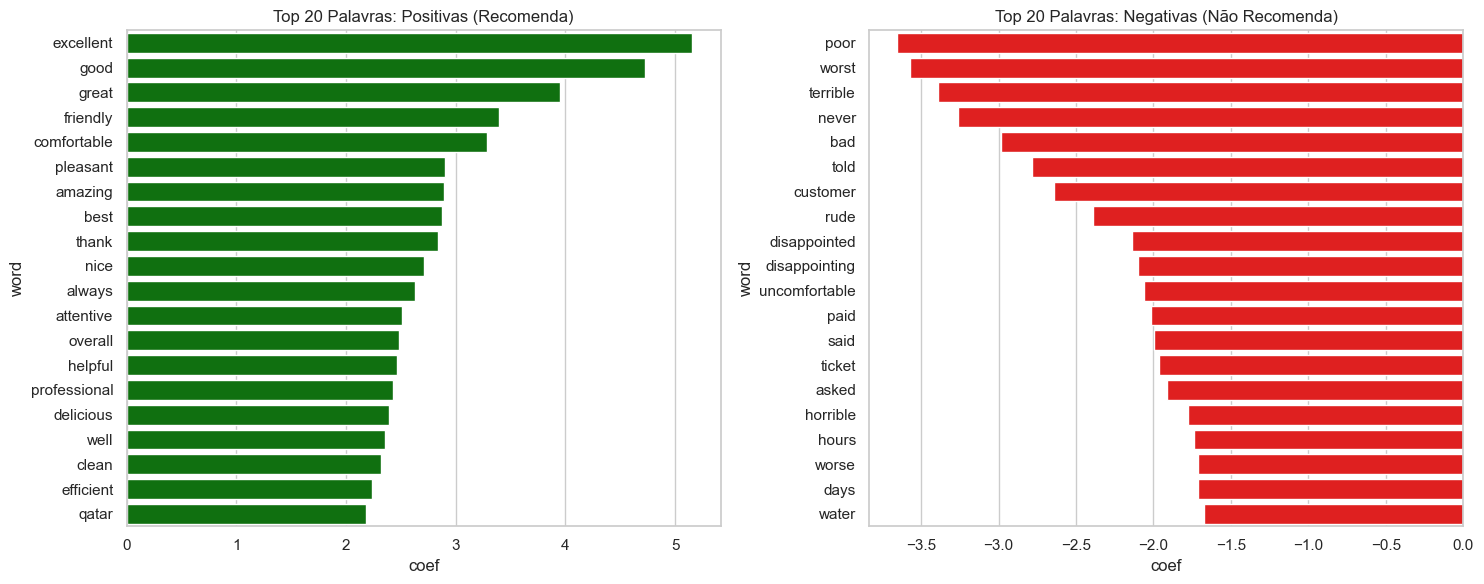

In [11]:
# Pegar nomes das features (palavras)
feature_names = tfidf.get_feature_names_out()
coefs = model_text.coef_[0]

# Criar DataFrame para ordenar
word_importance = pd.DataFrame({'word': feature_names, 'coef': coefs})

# Top 20 palavras que indicam "Recomenda" (Coeficiente Positivo Alto)
top_positive = word_importance.sort_values(by='coef', ascending=False).head(20)

# Top 20 palavras que indicam "NÃO Recomenda" (Coeficiente Negativo Alto)
top_negative = word_importance.sort_values(by='coef', ascending=True).head(20)

print("Top Palavras para RECOMENDAÇÃO:")
print(top_positive)
print("\nTop Palavras para NÃO RECOMENDAÇÃO:")
print(top_negative)

# Plotar
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(data=top_positive, x='coef', y='word', ax=ax[0], color='green')
ax[0].set_title('Top 20 Palavras: Positivas (Recomenda)')

sns.barplot(data=top_negative, x='coef', y='word', ax=ax[1], color='red')
ax[1].set_title('Top 20 Palavras: Negativas (Não Recomenda)')

plt.tight_layout()
plt.show()

7. Visualização Final e Comparação

--- AVALIAÇÃO E VISUALIZAÇÃO DE DESEMPENHO ---


C:\Users\mathe\AppData\Local\Temp\ipykernel_2188\1079432013.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=resultados, x='Modelo', y='Acurácia', palette='viridis')


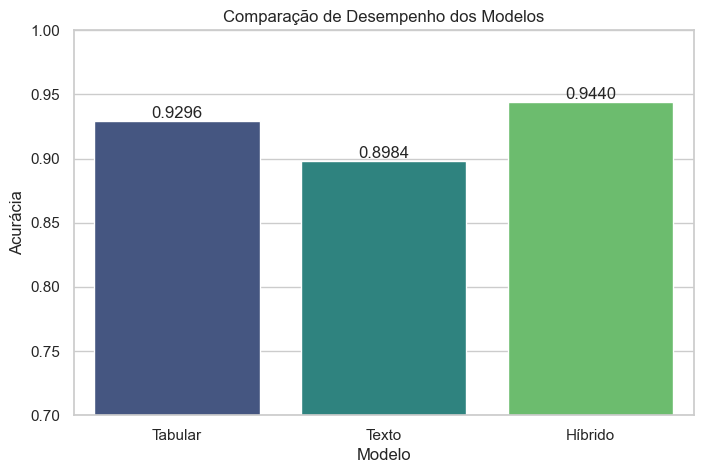

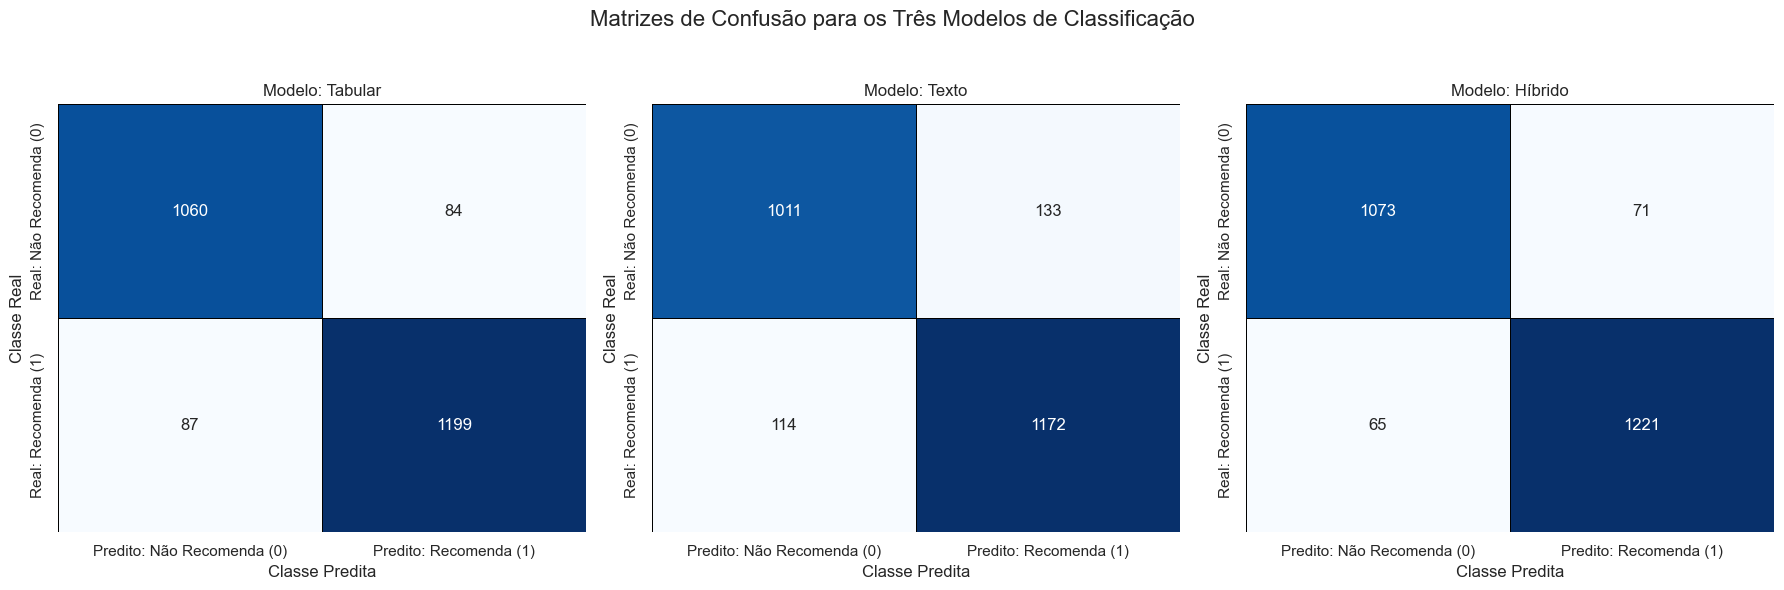

In [ ]:
print("--- AVALIAÇÃO E VISUALIZAÇÃO DE DESEMPENHO ---")

# 1. Comparação de Acurácia
acc_tab = accuracy_score(y_test, y_pred_tab)
acc_text = accuracy_score(y_test, y_pred_text)
acc_hybrid = accuracy_score(y_test, y_pred_hybrid)

resultados = pd.DataFrame({
    'Modelo': ['Tabular', 'Texto', 'Híbrido'],
    'Acurácia': [acc_tab, acc_text, acc_hybrid]
})

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=resultados, x='Modelo', y='Acurácia', palette='viridis')
plt.title('Comparação de Desempenho dos Modelos')
plt.ylim(0.7, 1.0)
for i in ax.containers:
    ax.bar_label(i, fmt='%.4f') # 4 casas decimais
plt.show()


# 2. Geração das Três Matrizes de Confusão

# Lista de modelos e previsões
models = ['Tabular', 'Texto', 'Híbrido']
predictions = [y_pred_tab, y_pred_text, y_pred_hybrid]

# Configuração do gráfico para 3 subplots em uma linha
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Matrizes de Confusão para os Três Modelos de Classificação', fontsize=16)

for i, (model_name, y_pred) in enumerate(zip(models, predictions)):
    cm = confusion_matrix(y_test, y_pred)
    
    # Criar um DataFrame para rotular a matriz com clareza
    cm_df = pd.DataFrame(cm, 
                         index = ['Real: Não Recomenda (0)', 'Real: Recomenda (1)'], 
                         columns = ['Predito: Não Recomenda (0)', 'Predito: Recomenda (1)'])
    
    # Plotar o heatmap
    sns.heatmap(cm_df, 
                annot=True, 
                fmt='d',
                cmap='Blues', 
                cbar=False, 
                ax=axes[i],
                linewidths=0.5,
                linecolor='black')
    
    axes[i].set_title(f'Modelo: {model_name}')
    axes[i].set_ylabel('Classe Real')
    axes[i].set_xlabel('Classe Predita')

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Ajusta o layout
plt.show()